
###Automated stock trading using FinRL

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:

Action: The action space describes the allowed actions that the agent interacts with the environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s', i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively

State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so our trading agent observes many different features to better learn in an interactive environment.

Environment: Dow 30 consituents

Install all the packages through FinRL library

In [6]:
!python --version



Python 3.11.11


In [7]:
!python -m pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-ue0mwfq1
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-ue0mwfq1
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 8cf3cacc6f570d26b430e403ea522c8fe9e6876a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-3_737wmh/elegantrl_5b4f6322395942cba9729520b016450f
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-3_737wmh/elegantrl_5b4f6322395942cba9729520b016450f
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 3bdc958c8e624b61a9e661832b01fef816924f61
  Preparing metadata (setup.py) ... done


In [8]:
!pip3 install pandas
!pip install numpy

In [9]:
!set PATH=%PATH%;C:\Users\natna\miniforge3\envs\finRl\Scripts


/bin/bash: line 1: C:Usersnatnaminiforge3envsfinRlScripts: command not found


In [10]:
!python -m pip install numpy==1.26.4 scipy==1.12.0 scikit-learn==1.6.1



# !python --version 1.23

In [11]:
import numpy
import scipy
import sklearn
print("Numpy version:", numpy.__version__)
print("Scipy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)


Numpy version: 1.26.4
Scipy version: 1.12.0
Scikit-learn version: 1.6.1


In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns

/home/aboba/anaconda3/envs/finrl_env/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Import Packages

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [14]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


Create Folders

In [15]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

Download Data

In [16]:
import requests
import pandas as pd
import time

API_KEY = "Y9VLVP8TVKQBB5LK"  # Replace with your Alpha Vantage API Key

# FinRL requires "tic" instead of "ticker"
DOW_30_TICKERS = [
    "AXP", "AMGN", "AAPL", "BA", "CAT", "CSCO", "CVX", "GS", "HD", "HON", 
    "IBM", "INTC", "JNJ", "KO", "JPM", "MCD", "MMM", "MRK", "MSFT", "NKE", 
    "PG", "TRV", "UNH", "CRM", "VZ", "V", "WBA", "WMT", "DIS", "DOW"
]

def fetch_alpha_vantage_data(symbol, start_date, end_date):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    
    if "Time Series (Daily)" not in data:
        print(f"Skipping {symbol}: No data returned.")
        return None
    
    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    df.index = pd.to_datetime(df.index)  # Ensure index is in datetime format
    
    # Rename columns to match FinRL's expected format
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adj_close",
        "6. volume": "volume",
    })
    
    # Keep only necessary columns for FinRL
    df = df[["open", "high", "low", "close", "volume"]].astype(float)

    # Filter by date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    
    # Reset index and rename columns
    df = df.reset_index()
    df.rename(columns={"index": "date"}, inplace=True)
    
    # Add ticker column, rename it to "tic" to match FinRL
    df["tic"] = symbol
    
    # Add "day" column representing the day of the week
    df["day"] = df["date"].dt.day_name()

    return df

# Set date range
start_date = "2009-01-01"
end_date = "2020-09-30"

# Fetch data for all tickers
all_data = []
for ticker in DOW_30_TICKERS:
    print(f"Fetching data for {ticker}...")
    df = fetch_alpha_vantage_data(ticker, start_date, end_date)
    if df is not None:
        all_data.append(df)
    time.sleep(12)  # Respect Alpha Vantage API rate limits

# Combine all stock data
if all_data:
    final_df = pd.concat(all_data).sort_values(by=["date", "tic"]).reset_index(drop=True)
    
    # Save to CSV for future use
    final_df.to_csv("dow_30_alpha_vantage.csv", index=False)
    print("Data saved to dow_30_alpha_vantage.csv")

    # Display DataFrame (Jupyter Notebook)
    from IPython.display import display
    display(final_df.head())

else:
    print("No data retrieved.")


Fetching data for AXP...


Fetching data for AMGN...
Fetching data for AAPL...
Fetching data for BA...
Fetching data for CAT...
Fetching data for CSCO...
Fetching data for CVX...
Fetching data for GS...
Fetching data for HD...
Fetching data for HON...
Fetching data for IBM...
Fetching data for INTC...
Fetching data for JNJ...
Fetching data for KO...
Fetching data for JPM...
Fetching data for MCD...
Fetching data for MMM...
Fetching data for MRK...
Fetching data for MSFT...
Fetching data for NKE...
Fetching data for PG...
Fetching data for TRV...
Fetching data for UNH...
Fetching data for CRM...
Fetching data for VZ...
Fetching data for V...
Fetching data for WBA...
Fetching data for WMT...
Fetching data for DIS...
Fetching data for DOW...
Data saved to dow_30_alpha_vantage.csv


,date,open,high,low,close,volume,tic,day
0,2009-01-02,85.880,91.04,85.16,90.75,26643400.0,AAPL,Friday
1,2009-01-02,58.586,59.08,57.75,58.99,6547900.0,AMGN,Friday
2,2009-01-02,18.570,19.52,18.40,19.33,10955700.0,AXP,Friday
3,2009-01-02,42.800,45.56,42.78,45.25,7010200.0,BA,Friday
4,2009-01-02,44.910,46.98,44.71,46.91,7117200.0,CAT,Friday


In [17]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("dow_30_alpha_vantage.csv")

# Define the new column order
column_order = ["date", "close", "high", "low", "open", "volume", "tic", "day"]

# Reorder the columns
df = df[column_order]

# Save the modified DataFrame back to CSV
df.to_csv("dow_30_alpha_vantage.csv", index=False)

# Print the first few rows to verify
print(df.head())
# Print the shape of the DataFrame
print("Final DataFrame shape:", df.shape)


         date  close   high    low    open      volume   tic     day
0  2009-01-02  90.75  91.04  85.16  85.880  26643400.0  AAPL  Friday
1  2009-01-02  58.99  59.08  57.75  58.586   6547900.0  AMGN  Friday
2  2009-01-02  19.33  19.52  18.40  18.570  10955700.0   AXP  Friday
3  2009-01-02  45.25  45.56  42.78  42.800   7010200.0    BA  Friday
4  2009-01-02  46.91  46.98  44.71  44.910   7117200.0   CAT  Friday
Final DataFrame shape: (86141, 8)


In [18]:
# import pandas as pd

# # Load the saved DataFrame
# df = pd.read_csv("dow_30_alpha_vantage.csv")

# # Print the shape of the DataFrame
# print("Final DataFrame shape:", df.shape)


Add technical Indicators

In [19]:
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=True,
                      user_defined_feature = False).preprocess_data(df.copy())

Successfully added technical indicators
Successfully added turbulence index


In [20]:
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values
  cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,cov_list
0,2010-01-04,214.0100,214.50,212.38,213.43,17633200.0,AAPL,Monday,3.926500,216.120085,184.013115,62.133693,168.824972,33.791146,200.215067,198.461035,0.0,"[[0.00044286396497949496, 0.000136279452896870..."
1,2010-01-04,57.7153,57.87,56.56,56.63,5277400.0,AMGN,Monday,0.321976,58.336137,54.827393,52.837126,89.522331,6.342377,56.572843,56.466088,0.0,"[[0.00044286396497949496, 0.000136279452896870..."
2,2010-01-04,40.9200,41.10,40.39,40.81,6894300.0,AXP,Monday,0.358722,42.069351,39.195649,56.709850,2.090007,11.537061,40.779667,38.808333,0.0,"[[0.00044286396497949496, 0.000136279452896870..."
3,2010-01-04,56.1800,56.39,54.80,55.72,6186700.0,BA,Monday,0.624170,56.477775,53.768225,58.509698,83.154852,10.897319,54.308333,52.441000,0.0,"[[0.00044286396497949496, 0.000136279452896870..."
4,2010-01-04,58.5500,59.19,57.51,57.65,7325600.0,CAT,Monday,0.103079,59.133358,56.340642,55.129890,51.387462,8.569462,57.971333,57.483833,0.0,"[[0.00044286396497949496, 0.000136279452896870..."


In real life trading, the model needs to be updated periodically using rolling windows. But here I'm just cutting the data into train and trade set.

In [21]:
train = data_split(df, '2009-01-01','2019-12-31')
trade = data_split(df, '2020-01-01','2020-09-30')

State Space and Action Space Calculation

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension

In [23]:
print(stock_dimension)
print(state_space)

29
291


## Environment Details

In [24]:
# Define transaction cost lists for buying and selling stocks
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# Explanation: 
# - `buy_cost_list` and `sell_cost_list` represent the transaction costs as a percentage for buying and selling stocks.
# - `[0.001] * stock_dimension` creates a list where each element is 0.001 (0.1% transaction fee), repeated for each stock.
# - The use of `=` assigns the same list to both `buy_cost_list` and `sell_cost_list`.

# Initialize the list to track the number of shares owned for each stock
num_stock_shares = [0] * stock_dimension
# Explanation:
# - `num_stock_shares` is a list where each element is initialized to 0, representing that no shares are owned initially.
# - `[0] * stock_dimension` ensures the list length matches the number of stocks (`stock_dimension`).

# Create a dictionary to store environment configuration parameters
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS,  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4  # Scaling factor for rewards to normalize them and improve learning stability.
}
# Explanation:
# - This dictionary (`env_kwargs`) encapsulates all the necessary parameters required to initialize the stock trading environment.
# - It includes configuration for portfolio management (e.g., `hmax`, `initial_amount`, `num_stock_shares`) and the structure of the RL problem (e.g., `state_space`, `action_space`).

# Initialize the stock trading environment with the training data and configuration parameters
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
# Explanation:
# - `StockTradingEnv` is a custom environment class for stock trading, compliant with OpenAI Gym standards.
# - `df=train` specifies the training data (a DataFrame containing historical stock prices and other features).
# - `**env_kwargs` unpacks the `env_kwargs` dictionary, passing each key-value pair as an argument to the environment initializer.
# - The environment simulates the stock trading process, enabling the RL agent to interact with it by observing states, taking actions, and receiving rewards.


Environment for training

In [25]:
env_train, _ = e_train_gym.get_sb_env() #get stable baseline environment for training
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [26]:
agent = DRLAgent(env = env_train)
# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

In [27]:
from stable_baselines3.common.logger import configure

 Implement DRL Algorithms

In [28]:
import torch

print('Current version of PyTorch: ', torch.__version__)

if torch.cuda.is_available:
  print('PyTorch can use GPUs!')
else:
  print('PyTorch cannot use GPUs.')

Current version of PyTorch:  2.6.0+cu124
PyTorch can use GPUs!


DDPG

Training

In [29]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [30]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 59        |
|    time_elapsed    | 168       |
|    total_timesteps | 10060     |
| train/             |           |
|    actor_loss      | 10.1      |
|    critic_loss     | 1.51      |
|    learning_rate   | 0.001     |
|    n_updates       | 9959      |
|    reward          | -1.422987 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 59        |
|    time_elapsed    | 338       |
|    total_timesteps | 20120     |
| train/             |           |
|    actor_loss      | 2.89      |
|    critic_loss     | 0.914     |
|    learning_rate   | 0.001     |
|    n_updates       | 20019     |
|    reward          | -1.422987 |
----------------------------------
day: 2514, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2492180.22
total_rew

KeyboardInterrupt: 

In [ ]:
trained_ddpg.save(config.TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None


Trading

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.tail()

,date,account_value
183,2020-09-23,731026.27016
184,2020-09-24,733934.61016
185,2020-09-25,747618.41016
186,2020-09-28,767885.21016
187,2020-09-29,761342.57016


Backtesting Performance

In [ ]:
import requests
import pandas as pd
import time

# Alpha Vantage API Key
API_KEY = "Y9VLVP8TVKQBB5LK"

# List of tickers to fetch (to be aggregated into a single DJI ticker)
tck = [
    "AXP", "AMGN", "AAPL", "BA", "CAT", "CSCO", "CVX", "GS", "HD", "HON", 
    "IBM", "INTC", "JNJ", "KO", "JPM", "MCD", "MMM", "MRK", "MSFT", "NKE", 
    "PG", "TRV", "UNH", "CRM", "VZ", "V", "WBA", "WMT", "DIS", "DOW"
]

# Function to fetch data for a single ticker
def fetch_stock_data(symbol, start_date, end_date):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    
    if "Time Series (Daily)" not in data:
        print(f"Skipping {symbol}: No data returned.")
        return None
    
    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    df.index = pd.to_datetime(df.index)  # Ensure index is in datetime format

    # Rename columns to match required format
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    })

    # Keep only required columns
    df = df[["open", "high", "low", "close", "volume"]].astype(float)

    # Filter by date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    # Reset index and rename columns
    df = df.reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    return df

# Set date range
start_date = "2020-01-01"
end_date = "2020-09-30"

# Fetch data for all tickers
all_data = []
for ticker in tck:
    print(f"Fetching data for {ticker}...")
    df = fetch_stock_data(ticker, start_date, end_date)
    if df is not None:
        df["tic"] = ticker  # Add ticker identifier
        all_data.append(df)
    time.sleep(12)  # Respect Alpha Vantage API rate limits

# Combine all stock data
if all_data:
    combined_df = pd.concat(all_data)

    # Aggregate data to form a single DJI ticker dataset
    dji_df = combined_df.groupby("date").agg(
        {
            "close": "mean",   # Average closing price
            "high": "max",     # Highest high across all tickers
            "low": "min",      # Lowest low across all tickers
            "open": "mean",    # Average opening price
            "volume": "sum"    # Total trading volume
        }
    ).reset_index()

    # Add single DJI ticker identifier
    dji_df["tic"] = "DJI"

    # Add "day" column representing the day of the week
    dji_df["day"] = dji_df["date"].dt.day_name()

    # Ensure final DataFrame structure matches required format
    dji_df = dji_df[["date", "close", "high", "low", "open", "volume", "tic", "day"]]

    # Save to CSV for future use
    dji_df.to_csv("dji_combined_alpha_vantage.csv", index=False)
    print("Aggregated DJI data saved to dji_combined_alpha_vantage.csv")

    # Print shape of DataFrame
    print("Final DJI DataFrame shape:", dji_df.shape)

    # Display first few rows
    from IPython.display import display
    display(dji_df.head())

else:
    print("No data retrieved.")


Fetching data for AXP...
Fetching data for AMGN...
Fetching data for AAPL...
Fetching data for BA...
Fetching data for CAT...
Fetching data for CSCO...
Fetching data for CVX...
Fetching data for GS...
Fetching data for HD...
Fetching data for HON...
Fetching data for IBM...
Fetching data for INTC...
Fetching data for JNJ...
Fetching data for KO...
Fetching data for JPM...
Fetching data for MCD...
Fetching data for MMM...
Fetching data for MRK...
Fetching data for MSFT...
Fetching data for NKE...
Fetching data for PG...
Fetching data for TRV...
Fetching data for UNH...
Fetching data for CRM...
Fetching data for VZ...
Fetching data for V...
Fetching data for WBA...
Fetching data for WMT...
Fetching data for DIS...
Fetching data for DOW...
Aggregated DJI data saved to dji_combined_alpha_vantage.csv
Final DJI DataFrame shape: (189, 8)


,date,close,high,low,open,volume,tic,day
0,2020-01-02,152.709333,333.35,47.88,151.666000,235592412.0,DJI,Thursday
1,2020-01-03,151.432667,334.89,47.48,150.862000,215324802.0,DJI,Friday
2,2020-01-06,152.000667,334.86,47.01,150.397667,248422719.0,DJI,Monday
3,2020-01-07,151.465333,344.19,47.10,151.709333,243609471.0,DJI,Tuesday
4,2020-01-08,152.331333,334.03,46.81,151.274010,275863907.0,DJI,Wednesday


In [ ]:
# Load the DJI test dataset created earlier
df_dji = pd.read_csv("dji_combined_alpha_vantage.csv")
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

# Ensure it's sorted by date
df_dji= df_dji.sort_values(by="date").reset_index(drop=True)

# Print the shape of the DataFrame
print("Baseline DataFrame shape:", df_dji.shape)

# Run backtesting statistics using the DJI proxy dataset
baseline_stats = backtest_stats(df_dji, value_col_name="close")

# Display the baseline statistics
print(baseline_stats)


Baseline DataFrame shape: (189, 2)
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.306148
Cumulative returns    -0.238657
Annual volatility      0.537816
Sharpe ratio          -0.412949
Calmar ratio          -0.625106
Stability              0.109657
Max drawdown          -0.489753
Omega ratio            0.920943
Sortino ratio         -0.565376
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.865468
Daily value at risk   -0.068640
dtype: float64


In [ ]:
# #baseline stats
# print("==============Get Baseline Stats===========")
# df_dji= get_baseline(
#         ticker="DJI",
#         start = '2020-01-01',
#         end = '2020-09-30')

# stats = backtest_stats(df_dji, value_col_name = 'close')

Back Test Plot

In [ ]:
df_result_ddpg = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "ddpg": df_result_ddpg["account_value"],
        "dji": dji["close"],
    }
)
result
# Ensure df_account_value exists and is formatted correctly
# df_result_ddpg = df_account_value.set_index(df_account_value.columns[0])

# # Use df_djiinstead of dji, assuming it represents the DJI dataset
# result = pd.DataFrame(
#     {
#         "ddpg": df_result_ddpg["account_value"],
#         "dji": df_dji.set_index("date")["close"],  # Ensure matching index
#     }
# )

# # Display the result
# result


,ddpg,dji
date,,
2020-01-02,1.000000e+06,1000000.000000
2020-01-03,9.991380e+05,991639.891035
2020-01-06,9.994857e+05,995359.375546
2020-01-07,1.000555e+06,991853.805050
2020-01-08,1.000222e+06,997524.709252
...,...,...
2020-09-24,7.339346e+05,889620.368107
2020-09-25,7.476184e+05,901514.423916
2020-09-28,7.678852e+05,915119.791849


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

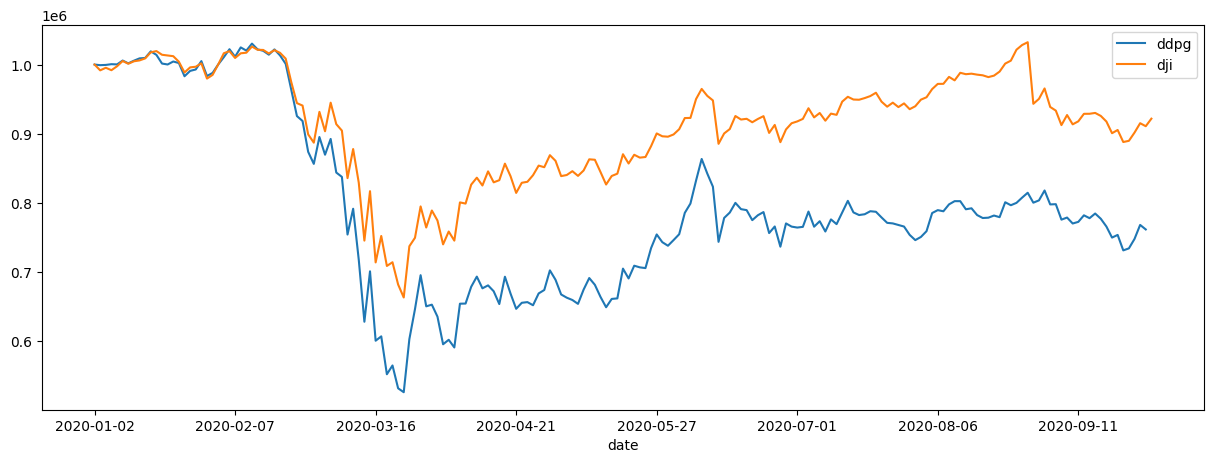

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/home/aboba/anaconda3/envs/finrl_env/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 167        |
|    iterations      | 1          |
|    time_elapsed    | 12         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.38988823 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016801588 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.07       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.65        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0365     |
|   

In [ ]:
trained_ppo.save(config.TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

Trading

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.tail()

,date,account_value
183,2020-09-23,494777.54056
184,2020-09-24,498344.41056
185,2020-09-25,509146.25056
186,2020-09-28,518130.00056
187,2020-09-29,514663.51056


Backtesting Performance

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.589495
Cumulative returns    -0.485336
Annual volatility      0.848233
Sharpe ratio          -0.385561
Calmar ratio          -0.888559
Stability              0.014984
Max drawdown          -0.663428
Omega ratio            0.886714
Sortino ratio         -0.418740
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.027652
Daily value at risk   -0.108165
dtype: float64


In [ ]:
# #baseline stats
# print("==============Get Baseline Stats===========")
# df_dji= get_baseline(
#         ticker="^DJI",
#         start = '2020-01-01',
#         end = '2020-09-30')

# stats = backtest_stats(df_dji, value_col_name = 'close')

# Load the DJI test dataset created earlier
df_dji = pd.read_csv("dji_combined_alpha_vantage.csv")
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

# Ensure it's sorted by date
df_dji= df_dji.sort_values(by="date").reset_index(drop=True)

# Print the shape of the DataFrame
print("Baseline DataFrame shape:", df_dji.shape)

# Run backtesting statistics using the DJI proxy dataset
baseline_stats = backtest_stats(df_dji, value_col_name="close")

# Display the baseline statistics
print(baseline_stats)



Baseline DataFrame shape: (189, 2)
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64


In [ ]:
df_result_ppo = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"],
        "dji": dji["close"],
    }
)
result
# Ensure df_account_value exists and is formatted correctly
# df_result_ppo = df_account_value.set_index(df_account_value.columns[0])

# # Use df_djiinstead of dji, assuming it represents the DJI dataset
# result = pd.DataFrame(
#     {
#         "ppo": df_result_ppo["account_value"],
#         "dji": df_dji.set_index("date")["close"],  # Ensure matching index
#     }
# )

# # Display the result
# result


,ppo,dji
date,,
2020-01-02,1.000000e+06,1000000.000000
2020-01-03,9.993166e+05,991639.891035
2020-01-06,9.999061e+05,995359.375546
2020-01-07,9.985881e+05,991853.805050
2020-01-08,1.001352e+06,997524.709252
...,...,...
2020-09-24,4.983444e+05,889620.368107
2020-09-25,5.091463e+05,901514.423916
2020-09-28,5.181300e+05,915119.791849


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

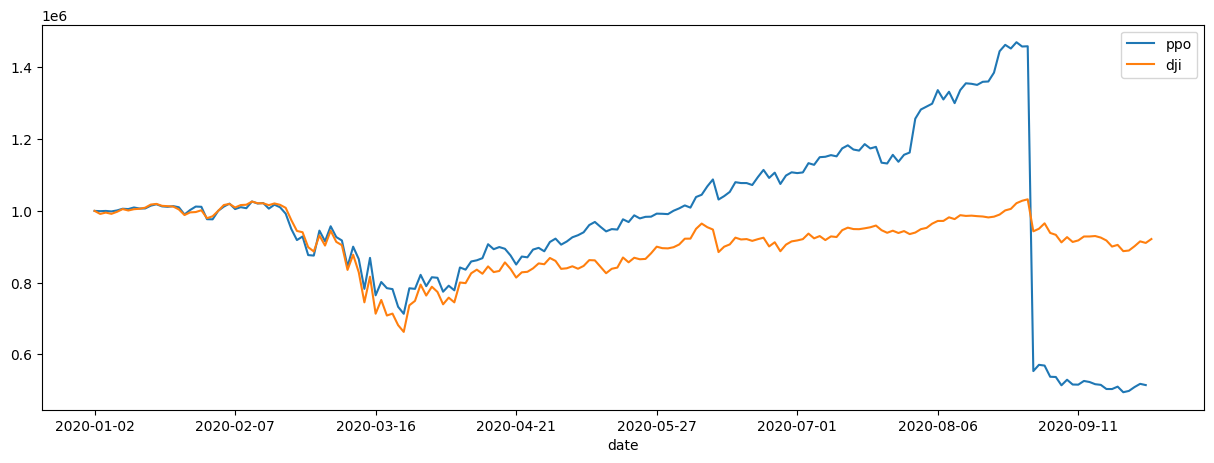

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

A2C

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


/home/aboba/anaconda3/envs/finrl_env/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 123        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.00525   |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -52.4      |
|    reward             | 0.35358793 |
|    std                | 1          |
|    value_loss         | 2.98       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 129        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | 0          |
|    learning_rate      |

In [ ]:
trained_a2c.save(config.TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

Trading

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.tail()

,date,account_value
183,2020-09-23,884591.59494
184,2020-09-24,885813.00494
185,2020-09-25,890356.79494
186,2020-09-28,902573.35494
187,2020-09-29,894668.85494


Backtesting Performance

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.138596
Cumulative returns    -0.105331
Annual volatility      0.393386
Sharpe ratio          -0.185247
Calmar ratio          -0.404688
Stability              0.022931
Max drawdown          -0.342476
Omega ratio            0.963928
Sortino ratio         -0.259125
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.049157
Daily value at risk   -0.049851
dtype: float64


In [ ]:
# #baseline stats
# print("==============Get Baseline Stats===========")
# df_dji= get_baseline(
#         ticker="^DJI",
#         start = '2020-01-01',
#         end = '2020-09-30')

# stats = backtest_stats(df_dji, value_col_name = 'close')
# Load the DJI test dataset created earlier
df_dji = pd.read_csv("dji_combined_alpha_vantage.csv")
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

# Ensure it's sorted by date
df_dji= df_dji.sort_values(by="date").reset_index(drop=True)

# Print the shape of the DataFrame
print("Baseline DataFrame shape:", df_dji.shape)

# Run backtesting statistics using the DJI proxy dataset
baseline_stats = backtest_stats(df_dji, value_col_name="close")

# Display the baseline statistics
print(baseline_stats)


Baseline DataFrame shape: (189, 2)
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64
Annual return         -0.103043
Cumulative returns    -0.078323
Annual volatility      0.419150
Sharpe ratio          -0.049860
Calmar ratio          -0.291096
Stability              0.005031
Max drawdown          -0.353983
Omega ratio            0.989931
Sortino ratio         -0.066729
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.780888
Daily value at risk   -0.052891
dtype: float64


In [ ]:
df_result_a2c = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        "dji": dji["close"],
    }
)
result
# # Ensure df_account_value exists and is formatted correctly
# df_result_a2c = df_account_value.set_index(df_account_value.columns[0])

# # Use df_djiinstead of dji, assuming it represents the DJI dataset
# result = pd.DataFrame(
#     {
#         "a2c": df_result_a2c["account_value"],
#         "dji": df_dji.set_index("date")["close"],  # Ensure matching index
#     }
# )

# # Display the result
# result


,a2c,dji
date,,
2020-01-02,1.000000e+06,1000000.000000
2020-01-03,9.983765e+05,991639.891035
2020-01-06,1.000217e+06,995359.375546
2020-01-07,9.989605e+05,991853.805050
2020-01-08,1.002339e+06,997524.709252
...,...,...
2020-09-24,8.858130e+05,889620.368107
2020-09-25,8.903568e+05,901514.423916
2020-09-28,9.025734e+05,915119.791849


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

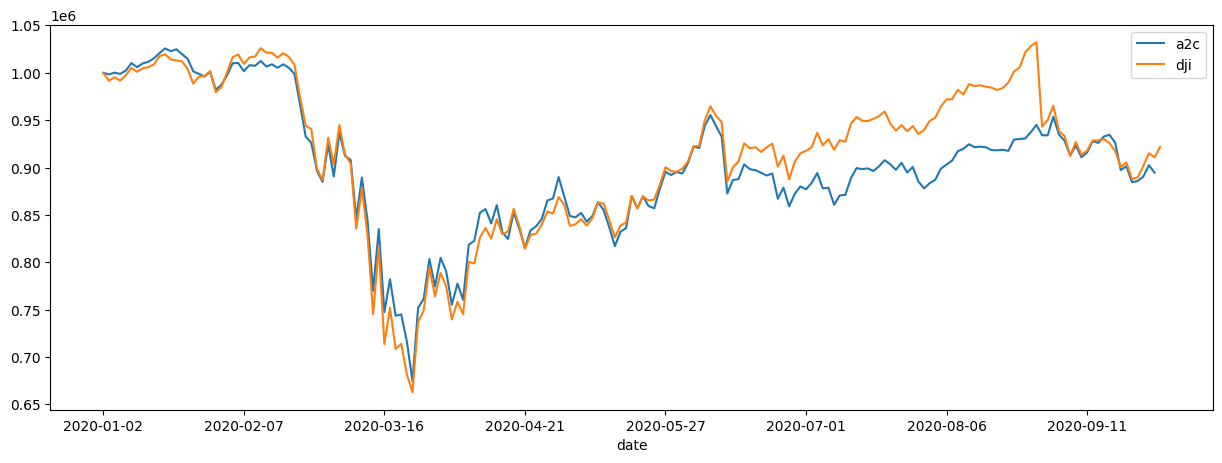

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [ ]:

plt.savefig('results.png')

<Figure size 1500x500 with 0 Axes>